
# Análise exploratória de dados com Python

A Base de Dados utilizada na análise pode ser encontrada em: https://www.kaggle.com/shivachandel/kc-house-data, contendo os dados das vendas de casas que ocorreram entre os anos de 2014 e 2015 em King County - Washington nos Estados Unidos. Uma série de informações correspondentes às casas estão contidas no arquivo, como o preço de venda, o tamanho, o número de cômodos, a localização, dentre outros.

O objetivo da análise é encontrar padrões contidos nos dados que possam fornecer insights relativos ao comportamento da dinâmica entre as características das casas e sua alteração no preço.

A análise contará com o bibliotecas Pandas, Numpy, Scipy, Seaborn e Matplotlib, que devem ser importadas:

In [192]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, ttest_ind, kstest, stats, skew, boxcox, norm, gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns

Carregamento dos dados:

In [193]:
data = pd.read_csv(r'kc_house_data.csv')


Uma vez que os dados foram carregados é necessário verificar se existem dados faltantes no conjunto:

In [194]:
data.isnull().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

Foi verificado que nenhuma coluna possui dados faltantes.

O próximo passo é realizar a exclusão das colunas utilizadas na análise.


In [195]:
to_keep_columns = ['sqft_living', 'sqft_lot', 'price', 'floors', 'yr_built']
for column in data.columns:
    if column not in to_keep_columns:
        data = data.drop(column, axis=1)


As informações sobre o preço, tamanho do lote, tamanho da casa, número de andares e o ano em que a casa foi construida foram mantidas.

As colunas referentes à medidas de tamanho nos Estados Unidos usualmente usam Square Foot (Pé Quadrado) como base, para facilitar a visualização, estas serão convertidas para o Sistema Internacional de Unidades, Metro Quadrado (m²).

In [196]:
for column in data.columns:
    if column[0:4] == 'sqft':
        data[column] = data[column]*0.092903
        data = data.rename(columns={column : 'm2'+column[4:]})

Para facilitar a análise temporal do estudo uma nova coluna será anexada à base de dados, que irá corresponder ao quartil temporal onde a data se encontra.

Os quartis são valores dados a partir do conjunto de observações em uma ordem crescente, que dividem a distribuição em quatro partes iguais. O primeiro quartil, Q1, é o número que deixa 25% das observações abaixo e 75% acima, o segundo quartil separa os dados na metade exata, e assim por diante. 

In [197]:
q1 = np.percentile(data['yr_built'], 25)
q2 = np.percentile(data['yr_built'], 50)
q3 = np.percentile(data['yr_built'], 75)
print(f'O primeiro quartil corresponde às casas construídas até o ano de {int(q1)}.')
print(f'O segundo quartil corresponde às casas construídas entre os anos de {int(q1)+1} e {int(q2)}.')
print(f'O terceiro quartil corresponde às casas construídas entre os anos de {int(q2)+1} e {int(q3)}.')
print(f'O último quartil corresponde às casas construídas após o ano de {int(q3)+1}.')


O primeiro quartil corresponde às casas construídas até o ano de 1951.
O segundo quartil corresponde às casas construídas entre os anos de 1952 e 1975.
O terceiro quartil corresponde às casas construídas entre os anos de 1976 e 1997.
O último quartil corresponde às casas construídas após o ano de 1998.


In [198]:
yr_built_quart = []
for n in range(0,len(data)):
    if data['yr_built'][n] <= q1:      
        yr_built_quart.append(1)
    elif data['yr_built'][n] <= q2:
        yr_built_quart.append(2)
    elif data['yr_built'][n] <= q3:
        yr_built_quart.append(3)
    else:
        yr_built_quart.append(4)
data = data.assign(yr_built_quart = np.array(yr_built_quart))

A nova coluna foi adicionada à base de dados:

In [199]:
data.head(5)

,price,m2_living,m2_lot,floors,yr_built,yr_built_quart
0,221900.0,109.62554,524.901950,1.0,1955,2
1,538000.0,238.76071,672.803526,2.0,1951,1
2,180000.0,71.53531,929.030000,1.0,1933,1
3,604000.0,182.08988,464.515000,1.0,1965,2
4,510000.0,156.07704,750.656240,1.0,1987,3


O preço do metro quadrado é uma informação estritamente necessária para o estudo do preço de imóveis, porém é necessário decidir se as análises serão baseadas no tamanho do lote ou da casa, para isso um gráfico com as informações sobre esses diferentes tamanhos será plotado:

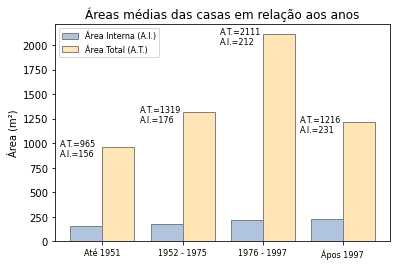

In [200]:
l1 = []
l2 = []

for n in range(1,5):
    l1.append(data['m2_living'].loc[data['yr_built_quart'] == n].mean())
    l2.append(data['m2_lot'].loc[data['yr_built_quart'] == n].mean())
    plt.text(x=n+1.67 , y =round(l2[n-1],2)-100  , s=f"A.I.={int(round(l1[n-1],0))}",fontdict={'size':8})
    plt.text(x=n+1.67 , y =round(l2[n-1],2), s=f"A.T.={int(round(l2[n-1],0))}",fontdict={'size':8})
ind = np.arange(3, 7)
width = 0.4
liv = plt.bar(ind, l1, width, label='Área Interna (A.I.)', color='lightsteelblue', linewidth=1, edgecolor='grey')
lot = plt.bar(ind+width, l2, width, label='Área Total (A.T.)', color='moccasin', linewidth=1, edgecolor='grey')
plt.ylabel('Área (m²)')
location = ind+width/2
labels = ['Até 1951', '1952 - 1975', '1976 - 1997', 'Ápos 1997']
plt.xticks(location, labels, fontsize=8)
plt.title('Áreas médias das casas em relação aos anos')
plt.legend(fontsize=8)



Como pode ser observado, a Área total das casas vendidas variou muito de acordo com o ano em que elas foram construidas, enquanto que a Área Interna das mesmas teve uma taxa de crescimento consideravelmente menor. 

Agora é necessário analisar o preço médio das casas em cada um dos diferentes recortes temporais:


In [201]:
for n in (1,2,3,4):
    print(round(data['price'].loc[data['yr_built_quart'] == n].mean(),2))


543934.79
468738.77
532868.85
618365.18


As médias de preço de venda em relação à quando elas foram construidas teve uma variação não tão significativa.

Portanto, para as análises posteriores a variável usada será o valor do metro quadrado considerando apenas a área interna do imóvel.

A coluna da área total do lote será excluída e uma nova coluna, correspondente ao preço do m2 de área interna será adicionada.

In [202]:
data = data.assign(price_m2_living = data['price'].values/data['m2_living'])
data = data.drop('m2_lot', axis=1)

In [203]:
data.head(5)

,price,m2_living,floors,yr_built,yr_built_quart,price_m2_living
0,221900.0,109.62554,1.0,1955,2,2024.163347
1,538000.0,238.76071,2.0,1951,1,2253.302061
2,180000.0,71.53531,1.0,1933,1,2516.239882
3,604000.0,182.08988,1.0,1965,2,3317.043210
4,510000.0,156.07704,1.0,1987,3,3267.617069


Um dos fatores que pode vir a alterar o valor do imóvel é o número de andares, para isso será realizada uma visualização dos diferentes números de andares do conjunto bem como a quantidade de casas correspondente à cada um dos números:

In [204]:
data.floors.value_counts()

1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: floors, dtype: int64

Algo que pode causar certo estranhamento inicial é perceber a existência casas com 1.5, 2.5 e 3.5 andares no conjunto. Essas unidades são correspondentes à casas com mezaninos (o que é relativamente comum nos Estados Unidos), que possuem um andar extra menor do que os outros.

O comportamento dos preços por m² dos imóveis em relação a presença mezanino é uma análise que pode gerar informações interessantes sobre o assunto.

Para isso os dados serão separados em dois conjuntos, correspondentes aos preços das casas com e sem mezanino, e suas médias serão calculadas:

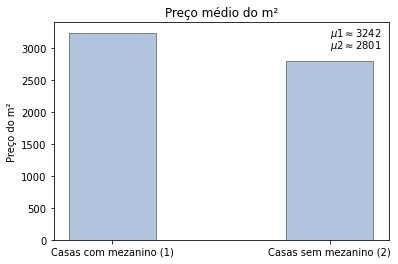

In [205]:
dt_with_hf = data['price_m2_living'].loc[data['floors'] % 1 != 0]
dt_without_hf = data['price_m2_living'].loc[data['floors'] % 1 == 0]
 
plt.bar([ 'Casas com mezanino (1)', 'Casas sem mezanino (2)'],[dt_with_hf.mean(),dt_without_hf.mean()],
color='lightsteelblue', width=0.4, linewidth=1, edgecolor='grey', align = 'center') 
plt.text(1, dt_with_hf.mean(), f'$ \mu1 \\approx {int(round(dt_with_hf.mean(),0))}$', color='black', va='center')
plt.text(1, dt_with_hf.mean()-200, f'$ \mu2 \\approx {int(round(dt_without_hf.mean(),0))} $', color='black', va='center')
plt.ylabel('Preço do m²')
plt.title('Preço médio do m²')
plt.show()


Como pode ser observado, as casas com mezanino possuem o m² mais valorizado, em média, porém é necessário conferir estatisticamente se há, de fato, uma diferença significativa.

Para isso, uma mostra de cada um dos dois conjuntos será aplicada no teste t-student, que tem por função empregar conceitos estatísticos para rejeitar ou não uma hipótese.

A condição para o uso do teste é que as amostras nele aplicadas tenham uma distribuição normal (também chamada de gaussiana), similar à apresentada abaixo:



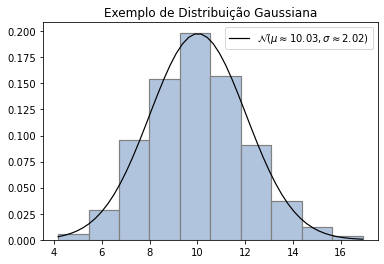

In [206]:

normal_sample = norm.rvs(loc=10, scale=2, size=1000)
domain = np.linspace(np.min(normal_sample), np.max(normal_sample))
plt.hist(normal_sample, density=True, color='lightsteelblue', linewidth=1.2,edgecolor='grey')
plt.plot(domain, norm.pdf(domain, normal_sample.mean(), normal_sample.std()),color='black', linewidth=1.2,
label='$\mathcal{N}$'+f'$( \mu \\approx {round(normal_sample.mean(),2)} , \sigma \\approx {round(normal_sample.std(),2)})$')
plt.title('Exemplo de Distribuição Gaussiana')
plt.legend()


O histograma acima possui uma distribuição normal, possuindo uma maior concentração de valores perto da média (no meio) e concentrações menores nas pontas. Também é chamado de histograma em "formato de sino". 

Antes da aplicação das amostras para conferir se há diferença estatística é necessário conferir se a distribuição das mesmas é gaussiana.

O histograma correspondente aos dados das casas com mezanino será plotado para a análise:


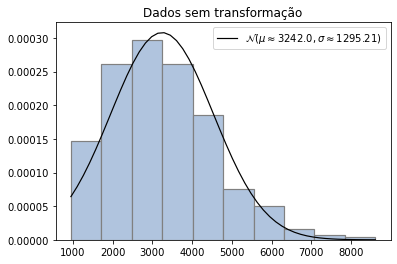

In [207]:
domain = np.linspace(np.min(dt_with_hf), np.max(dt_with_hf))
plt.hist(dt_with_hf, density=True, color='lightsteelblue', linewidth=1.2,edgecolor='grey')
plt.plot(domain, norm.pdf(domain, dt_with_hf.mean(), dt_with_hf.std()),color='black', linewidth=1.2,
label='$\mathcal{N}$'+f'$( \mu \\approx {round(dt_with_hf.mean(),2)} , \sigma \\approx {round(dt_with_hf.std(),2)})$')
plt.title('Dados sem transformação')
plt.legend()


Realizando uma observação superficial constata-se que os dados não se assemelham muito à uma distribuição normal, mas ainda assim, um teste com mais embasamento deve ser realizado, portanto, uma função que irá usar o teste de Kolmogorov-Smirnov será criada para poder checar a normalidade dos dados.

In [208]:
def check_normality(data):
    ks_critico =1.36/(np.sqrt(len(data)))
    if abs(skew(data))>0.2:
        print(f'O conjunto não possui uma distribuição gaussiana.')
    else:
       ks_stat, ks_p_valor = kstest(data,'norm', args=(data.mean(),data.std()))
       if ks_critico >= ks_stat:
           print(f'O conjunto possui uma distribuição gaussiana.')
       else:
           print(f'O conjunto não possui uma distribuição gaussiana.')

Uma vez que a função foi criada, a normalidade dos conjuntos com e sem mezanino serão testadas:

In [209]:
check_normality(dt_with_hf)
check_normality(dt_without_hf)

O conjunto não possui uma distribuição gaussiana.
O conjunto não possui uma distribuição gaussiana.


Como nenhum dos dois conjuntos pode ser classificado como distribuição gaussiana, uma nova função, que tem por objetivo normalizar os dados com o uso da transformação box-cox será criada.

Amostras de 1000 valores de cada um dos conjuntos serão usadas para a realização da transformação.

In [210]:
dt_with_hf_sample= np.random.choice(dt_with_hf,1000) 
dt_without_hf_sample= np.random.choice(dt_without_hf,1000)

def transform_to_gaussian(arr):
    x, lmbda = boxcox(arr)
    return x

dt_with_hf_transformed = transform_to_gaussian(dt_with_hf_sample)
dt_without_hf_transformed = transform_to_gaussian(dt_without_hf_sample)

Uma vez que os dados foram normalizados é necessário que sejam checados de novo.

In [211]:
check_normality(dt_with_hf_transformed)
check_normality(dt_without_hf_transformed)

O conjunto possui uma distribuição gaussiana.
O conjunto possui uma distribuição gaussiana.


Text(0.5, 1.0, 'Dados transformados')

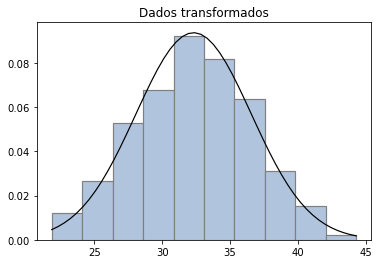

In [212]:

domain1 = np.linspace(np.min(dt_with_hf_transformed), np.max(dt_with_hf_transformed))
plt.hist(dt_with_hf_transformed, density=True, color='lightsteelblue', linewidth=1.2,edgecolor='grey')
plt.plot(domain1, norm.pdf(domain1, dt_with_hf_transformed.mean(), dt_with_hf_transformed.std()),color='black', linewidth=1.2)
plt.title('Dados transformados')


Text(0.5, 1.0, 'Dados transformados')

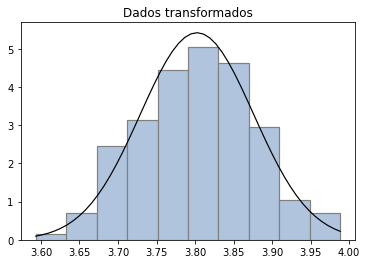

In [213]:
domain2 = np.linspace(np.min(dt_without_hf_transformed), np.max(dt_without_hf_transformed))
plt.hist(dt_without_hf_transformed, density=True, color='lightsteelblue', linewidth=1.2,edgecolor='grey')
plt.plot(domain2, norm.pdf(domain2, dt_without_hf_transformed.mean(), dt_without_hf_transformed.std()),color='black', linewidth=1.2)
plt.title('Dados transformados')

Os dados transformados agora podem ser aplicados na função t-student, que terá como hipótese nula (H0) a igualdade dos dados.

Portanto, se a hipótese nula for aceita, pode ser considerado que, com um grau de confiança de 95%, NÃO HÁ diferença estatística significativa entre casas com ou sem mezanino.

 No caso da hipótese nula ser rejeitada a diferença entre os dois conjuntos é constatada, portanto , pode ser afirmado que com um grau de 95% de confiança, casas com mezanino possuem um valor de m² mais elevado.



In [214]:
def compare_two_groups(arr1, arr2):
    alpha = 0.05
    stat, p = ttest_ind(arr1, arr2)
    print('Estatísticas= %.3f, p=%.3f' %(stat , p))
    if p > alpha:
        print('Mesma distribuição (Hipótese nula rejeitada)')
    else:
        print('Distribuição distinta. (Hipótese nula aceita)') 

compare_two_groups(dt_with_hf_transformed, dt_without_hf_transformed)

Estatísticas= 211.567, p=0.000
Distribuição distinta. (Hipótese nula aceita)


Portanto, pode ser considerado que há diferença estatística entre os dois conjuntos.

Casas com mezanino possuem um preço de m² superior à de casas sem mezanino.